# Interactome Construction and Analysis
Get data from local database and create the interactome

In [4]:
#Include libraries
import MySQLdb
import networkx as nx
from matplotlib import pylab as plt
import numpy as np

%matplotlib inline  

In [5]:
def get_ppi(lcc):
    '''
    Main function to extract the PPI from our local database.
    Connect to GenesGO Database and extract PPI edges from 
    
    '''
    # Open database connection
    db = MySQLdb.connect("<Server>", "readonly", "<Password>", "GenesGO")
    # prepare a cursor object using cursor() method
    cursor = db.cursor()

    sql = """
            SELECT
            e.entrez_1,
            e.entrez_2,
            g1.Locus_Type,
            g1.Locus_Group,
            g2.Locus_Type,
            g2.Locus_Group
            FROM networks.PPI_hippie2017 e
            INNER JOIN GenesGO.hgnc_complete g1 ON e.entrez_1 = g1.Entrez_Gene_ID_NCBI
            INNER JOIN GenesGO.hgnc_complete g2 ON e.entrez_2 = g2.Entrez_Gene_ID_NCBI
            WHERE
                (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'T cell receptor gene')                     # 0 links   
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'immunoglobulin gene')              # 4 links   
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'T cell receptor gene')             # 0 links
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'immunoglobulin gene')                 # 0 links        
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'T cell receptor gene' AND g2.Locus_Type = 'gene with protein product')       # 17 links        
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'T cell receptor gene')       # 1 links        
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'immunoglobulin gene' AND g2.Locus_Type = 'gene with protein product')        # 115 links        
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'immunoglobulin gene')        # 295 links   
                OR (e.author != '' AND e.entrez_1 != e.entrez_2
                    AND g1.Locus_Type = 'gene with protein product' AND g2.Locus_Type = 'gene with protein product')  # 309602 links 


        """
    try:
        # execute SQL query
        cursor.execute(sql)
        data = cursor.fetchall()

    except:
        print('SQL error')

    db.close()


    
    l_nodes = []
    for x in data:
        l_nodes.append(x[0])
        l_nodes.append(x[1])
    l_nodes = list(set(l_nodes))

    
    
    G = nx.Graph()
    G.add_nodes_from(l_nodes)
    
    for x in data:
        G.add_edge(x[0], x[1])

    print 'PPI All:'
    print 'Number of genes found: %d' %len(G.nodes())
    print 'Number of interactions found: %d' %len(G.edges())
    
    if lcc == 1:
        Nl_l = sorted(nx.connected_components(G))  # generates list of components node lists
        l = [len(x) for x in Nl_l]  # returns list of length of node lists
        idx = l.index(max(l))  # find the index of the maximal length i.e. lcc
        Nlcc = Nl_l[idx]  # pin down lcc
        G_lcc = G.subgraph(Nlcc)  # extract lcc graph
        G = G_lcc.copy()
        
        print 'PPI Only Largest Connected Component:'
        print 'Number of genes found: %d' %len(G.nodes())
        print 'Number of interactions found: %d' %len(G.edges())
        
    else:
        pass

    return G

In [6]:
#1 = get only biggest LCC; Remove single not connected nodes
PPI = get_ppi(1)
nx.write_gml(PPI, '../results/Interactome_Construction_And_Analysis/Human_Interactome.gml')

PPI All:
Number of genes found: 16393
Number of interactions found: 309365
PPI Only Largest Connected Component:
Number of genes found: 16376
Number of interactions found: 309355


## Degree Distributions

In [7]:
#Extract degrees from the PPI
degrees_PPI = [x[1] for x in  nx.degree(PPI)]

#Get the unique PPI degree steps
degrees_PPI_unique = list(set(degrees_PPI))
degrees_PPI_unique.sort()

#degree for x axis (sorted from small to biggest)
degreesPPI = []

#Normal distribution (i.e. P(k = x))
degreeDistributionPPI = []

#Cumulative distribution (i.e. P(k > x))
cumulativedegreeDistributionPPI = []
for degree in degrees_PPI_unique:
    degreesPPI.append(degree)
    degreeDistributionPPI.append(degrees_PPI.count(degree)/float(len(degrees_PPI)))
    cumulativedegreeDistributionPPI.append(len([x for x in degrees_PPI if x >= degree]) / float(len(degrees_PPI)))

#### Normal degree distribution (log/log scale)

/cm/shared/apps/python/2.7.13/lib/python2.7/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


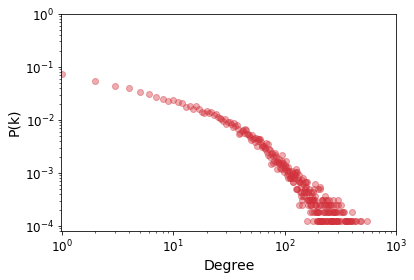

In [8]:
plt.scatter(degreesPPI, degreeDistributionPPI, c='#D2323C', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree', fontsize=14)
plt.ylabel('P(k)', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.ylim(10 ** -4.1, 1)
plt.xlim(0,1000)
#plt.title('Degree Distribution')
plt.savefig('../results/Interactome_Construction_And_Analysis/Scatter_DegreeDistribution_LogLog.pdf',format='pdf')
plt.show()
plt.close()

#### Cumulative degree distribution (log/log scale)

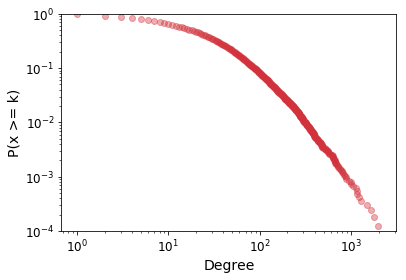

In [9]:
plt.scatter(degreesPPI, cumulativedegreeDistributionPPI, c='#D2323C', alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree', fontsize=14)
plt.ylabel('P(x >= k)', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.ylim(10 ** -4, 1)
#plt.title('Cumulative Degree Distribution')
plt.savefig('../results/Interactome_Construction_And_Analysis/Scatter_CumulativeDegreeDistribution_LogLog.pdf',format='pdf')
plt.show()
plt.close()

## Overall PPI stats

In [ ]:
print 'Number of nodes N: %d' %len(PPI.nodes())
print 'Number of edges M: %d' %len(PPI.edges())
print 'Mean degree <k>: %.2f' %np.mean(degrees_PPI)
print 'Mean clustering <c>: %.2f' %nx.average_clustering(PPI)
print 'Mean average shortest path <l>: %.2f' %nx.average_shortest_path_length(PPI)
print 'Diameter dmax: %.2f' %nx.diameter(PPI)

Number of nodes N: 16376
Number of edges M: 309355
Mean degree <k>: 37.78
Mean clustering <c>: 0.11
